In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import sklearn.metrics

In [113]:
# Code to predict proprty type based on combination of numeric and texttual attributes.

df_train = pd.read_csv('./Cleaned_Data/train_nlp_v00.csv')

In [114]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83049 entries, 0 to 83048
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      83049 non-null  int64  
 1   id              83049 non-null  int64  
 2   locationId      83049 non-null  int64  
 3   regionId        83049 non-null  int64  
 4   provinceId      83049 non-null  int64  
 5   countryId       83049 non-null  int64  
 6   typeId          83049 non-null  int64  
 7   price           76873 non-null  float64
 8   rooms           8486 non-null   float64
 9   bedrooms        70207 non-null  float64
 10  bathrooms       68227 non-null  float64
 11  totalArea       56709 non-null  float64
 12  livingArea      30921 non-null  float64
 13  plotArea        44257 non-null  float64
 14  terraceArea     17130 non-null  float64
 15  text_processed  82836 non-null  object 
dtypes: float64(8), int64(7), object(1)
memory usage: 10.1+ MB


In [115]:
df_train.drop(columns=['Unnamed: 0'], inplace=True)

In [116]:
df_train[df_train['text_processed'].isna()]

,id,locationId,regionId,provinceId,countryId,typeId,price,rooms,bedrooms,bathrooms,totalArea,livingArea,plotArea,terraceArea,text_processed
849,1020,27,3,2,1,2,4950000.0,NaN,6.0,7.0,NaN,1008.0,1400.0,232.0,NaN
1078,1312,97,269,2,1,2,4250000.0,7.0,4.0,NaN,NaN,646.0,2000.0,150.0,NaN
2141,2573,67,8,2,1,2,2680000.0,6.0,3.0,NaN,NaN,648.0,14000.0,NaN,NaN
4590,5698,15,3,2,1,2,990000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5740,7100,65,7,2,1,2,300000.0,NaN,NaN,NaN,NaN,150.0,50000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81675,103224,27,3,2,1,2,1400000.0,NaN,4.0,4.0,NaN,280.0,NaN,60.0,NaN
82558,104432,139,132,131,130,1,850000.0,NaN,1.0,1.0,NaN,73.0,NaN,13.0,NaN
82559,104433,135,132,131,130,1,915000.0,NaN,2.0,2.0,NaN,128.0,NaN,88.0,NaN
82707,104639,48,5,2,1,4,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN


In [117]:
# Drop rows with null attributes.

df_train.drop(df_train[df_train['text_processed'].isna()].index.tolist(), inplace=True)

In [118]:
# Drop extraneous columns.

df_train.drop(columns=['id','locationId','regionId','provinceId','countryId'], inplace=True)

In [119]:
# Drop housing types which are not 'housing' or 'apartment'.

df_train.drop(df_train[df_train['typeId']==3].index.tolist(), inplace=True)

df_train.drop(df_train[df_train['typeId']==4].index.tolist(), inplace=True)

df_train.drop(df_train[df_train['typeId']==5].index.tolist(), inplace=True)

In [122]:
# Reset the index of the final dataset.

df_train.reset_index(inplace=True)

In [123]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74906 entries, 0 to 74905
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           74906 non-null  int64  
 1   typeId          74906 non-null  int64  
 2   price           69217 non-null  float64
 3   rooms           8277 non-null   float64
 4   bedrooms        68990 non-null  float64
 5   bathrooms       66877 non-null  float64
 6   totalArea       54488 non-null  float64
 7   livingArea      29811 non-null  float64
 8   plotArea        38246 non-null  float64
 9   terraceArea     16774 non-null  float64
 10  text_processed  74906 non-null  object 
dtypes: float64(8), int64(2), object(1)
memory usage: 6.3+ MB


In [124]:
# Convert the housing types in 0 or 1 for binary classification.

df_train['typeId'][df_train['typeId']==1] = 0

df_train['typeId'][df_train['typeId']==2] = 1

/var/folders/_w/k40rbx_x0yd88dyx542lggnc0000gn/T/ipykernel_26914/4266793782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['typeId'][df_train['typeId']==1] = 0


In [126]:
# Create a result set.

y = df_train['typeId']

In [127]:
# Drop the result column from the input dataset.

df_train.drop(columns=['typeId'], inplace=True)

In [128]:
y.shape

(74906,)

In [129]:
# Perform TFIDVectorizer on the text attributes.

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(max_features=5000).fit_transform(df_train['text_processed'])

type(vec)

scipy.sparse._csr.csr_matrix

In [130]:
vec.shape

(74906, 5000)

In [131]:
# Convert the vectorized array list into a dataframe.

df_text_vectorized = pd.DataFrame(vec.toarray())

In [132]:
df_text_vectorized

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
df_train.drop(columns=['text_processed', 'index'], inplace=True)

In [134]:
# Create final input dataset with both numeric and vectorized text attributes.

df_train = df_train.join(df_text_vectorized)

In [135]:
df_train

,price,rooms,bedrooms,bathrooms,totalArea,livingArea,plotArea,terraceArea,0,1,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,26500000.0,20.0,10.0,16.0,4000.0,2800.0,820000.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,26500000.0,NaN,10.0,12.0,3000.0,NaN,1200000.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26500000.0,NaN,10.0,12.0,3000.0,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26500000.0,NaN,10.0,12.0,3000.0,NaN,1200000.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26500000.0,NaN,10.0,12.0,NaN,NaN,1200000.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74901,315000.0,NaN,2.0,2.0,140.0,110.0,NaN,30.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74902,310000.0,NaN,3.0,2.0,88.0,88.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74903,310000.0,NaN,3.0,1.0,85.0,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74904,NaN,NaN,4.0,3.0,NaN,120.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
# Perform train text split.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=42)

In [137]:
# Train XGBoost classifier on the training dataset.

import xgboost as xgb 

xgb_cl_pty = xgb.XGBClassifier(max_depth=15, learning_rate=0.09, n_estimators=175, random_state=42)

xgb_cl_pty.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.09, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=15, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=175, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

accuracy Score: 0.9841810172206648


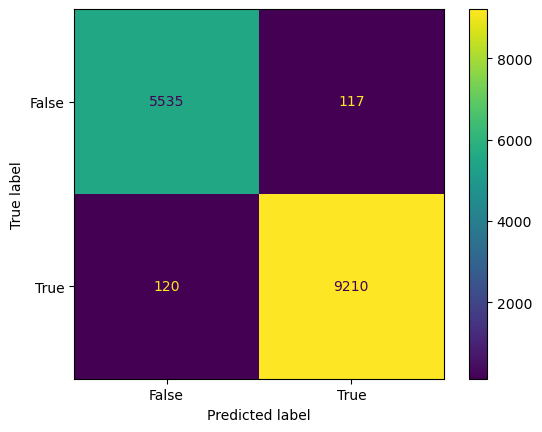

In [138]:
# Determine Confusion Matrix and Accuracy Score.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = xgb_cl_pty.predict(X_test)

print("accuracy Score:", accuracy_score(y_test, y_pred))

confusion_matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()

plt.show()

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_text_vectorized, y, test_size=0.2, random_state=42)

In [92]:
# Train model only on textual attributes.

import xgboost as xgb 

xgb_cl_pty_nlp_only = xgb.XGBClassifier(max_depth=15, learning_rate=0.09, n_estimators=175, random_state=42)

xgb_cl_pty_nlp_only.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.09, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=15, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=175, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

accuracy Score: 0.9805766920304365


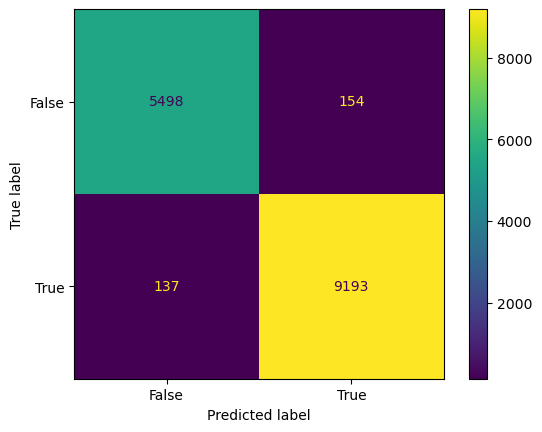

In [93]:
# Determine confusion matrix and accuracy score.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = xgb_cl_pty_nlp_only.predict(X_test)

print("accuracy Score:", accuracy_score(y_test, y_pred))

confusion_matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()

plt.show()

In [94]:
# save the models to files.

import pickle

# Save to a file using Pickle
with open('model_xgb_pty.pkl', 'wb') as file_handle: # wb=write binary
    pickle.dump(xgb_cl_pty, file_handle)

# Save to a file using Pickle
with open('model_xgb_pty_nlp_only.pkl', 'wb') as file_handle: # wb=write binary
    pickle.dump(xgb_cl_pty_nlp_only, file_handle)